# Problem Statement: Surf and  Ultimate, which is the better plan?


I work as an analyst for the telecom operator Megaline. The company has two prepaid plans, Surf and Ultimate, and the commercial department is keen on understanding which of these plans generates more revenue to optimize their advertising budget.

I am tasked with a preliminary analysis based on a sample of 500 Megaline clients. This analysis will include details about the clients, such as their demographics, the prepaid plan they are using, and their usage statistics in terms of calls made and text messages sent during the year 2018. My objective is to examine the clients' behavior and identify which prepaid plan is more profitable for Megaline.

# Table of Contents: <a id = 'back'></a>

* [1.Loading and Cleaning Data](#prep) 
* [2.Exploratory Data Analysis](#explore)
* [3.Testing Statistical Hypotheses](#test)
* [4.Conclusion](#end)

## Initialization

In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from math import factorial 
from scipy import stats as st
import math as mt
import matplotlib.dates as mdates


/Users/kevinklev/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading and Cleaning Data <a id = 'prep'></a>

In [18]:
# loading data sets
try: 
    calls_df = pd.read_csv('megaline/megaline_calls.csv')
    int_df = pd.read_csv('megaline/megaline_internet.csv')
    mess_df = pd.read_csv('megaline/megaline_messages.csv')
    plans_df = pd.read_csv('megaline/megaline_plans.csv')
    users_df = pd.read_csv('megaline/megaline_users.csv')

except:
    calls_df = pd.read_csv('project_git/megaline/megaline_calls.csv')
    int_df = pd.read_csv('project_git/megaline/megaline_internet.csv')
    mess_df = pd.read_csv('project_git/megaline/megaline_messages.csv')
    plans_df = pd.read_csv('project_git/megaline/megaline_plans.csv')
    users_df = pd.read_csv('project_git/megaline/megaline_users.csv')

## Plans Dataframe

In [19]:
# looking at plans_df general info
plans_df.info()
plans_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Pretty straightforward. Data looks good to go here for the most part. Going to change the names of the messag/minute/gb columns to indicate that these are values for any overages. 

In [63]:
# changing names of columns to ones i find a bit more fitting
plans_df.rename(columns = {'messages_included':'messages_per_month_included',
                           'plan_name':'plan',
                           'minutes_included': 'minutes_per_month_included', 
                           'usd_per_gb':'usd_per_gb_overage', 
                           'usd_per_message':'usd_per_message_overage', 
                           'usd_per_minute':'usd_per_minute_overage'},
               inplace = True)
plans_df

,plan,messages_per_month_included,mb_per_month_included,minutes_per_month_included,usd_monthly_pay,usd_per_gb_overage,usd_per_message_overage,usd_per_minute_overage
0,surf,50,15360,500,20,10,0.03,0.03
1,ultimate,1000,30720,3000,70,7,0.01,0.01


In [21]:
# plalcing plan names at front of dataframe
plans_df.set_index('plan_name', inplace = True)
plans_df.reset_index(inplace = True)

## Users Dataframe

In [22]:
users_df.info()
display(users_df.head(5))
users_df.sample(5)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
210,1210,Shanae,Carrillo,30,"Oklahoma City, OK MSA",2018-06-01,surf,NaN
434,1434,Kai,Barr,18,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-03-06,surf,NaN
247,1247,Marion,Singleton,75,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-04-12,ultimate,NaN
335,1335,Gail,Coleman,61,"Dallas-Fort Worth-Arlington, TX MSA",2018-06-02,surf,NaN
11,1011,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaN


General observations:
    
    -user_id needs to be changed to an object 
    
    -reg_date and churn_date need to be changed to datetime objects 
    
    -makes sense that there are so few values in the churn date column given most accounts were active 
    throughout the year

    - going to rename city column and remove MSA - more representative of the data 


In [23]:
# converting the the proper data types

users_df['user_id'] = users_df['user_id'].astype('object')
users_df['reg_date']= pd.to_datetime(users_df['reg_date'], format= '%Y-%m-%d')
users_df['churn_date']= pd.to_datetime(users_df['churn_date'], format= '%Y-%m-%d', errors = 'coerce')

users_df.dtypes

user_id               object
first_name            object
last_name             object
age                    int64
city                  object
reg_date      datetime64[ns]
plan                  object
churn_date    datetime64[ns]
dtype: object

In [24]:
# addressing duplicate and null values
print('Duplicates: {}'.format(users_df[['user_id','first_name', 'last_name']].duplicated().sum()))
print('Missing values: {}'.format(users_df.isna().sum()))



Duplicates: 0
Missing values: user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64


In [25]:
# dropping churn_date column
users_df.drop('churn_date', inplace = True, axis = 1)

In [26]:
# dropping city column and creating msa column
msa = []

for i in users_df['city']:
    split = i.split(' ')[0:-1]
    area = ' '.join(split)
    msa.append(area)
    
users_df['msa'] = msa


In [27]:
users_df.head(5)

,user_id,first_name,last_name,age,city,reg_date,plan,msa
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,"Atlanta-Sandy Springs-Roswell, GA"
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,"Seattle-Tacoma-Bellevue, WA"
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,"Las Vegas-Henderson-Paradise, NV"
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,"Tulsa, OK"
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,"Seattle-Tacoma-Bellevue, WA"


## Calls

In [28]:
calls_df = pd.read_csv('megaline/megaline_calls.csv')

In [29]:
# looking at general info for calls_df 
calls_df.info()
display(calls_df.head(5))
calls_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


,id,user_id,call_date,duration
28541,1109_168,1109,2018-11-21,3.76
76924,1277_0,1277,2018-10-05,5.55
101559,1362_308,1362,2018-07-01,6.73
49564,1179_223,1179,2018-07-30,0.92
70871,1252_247,1252,2018-11-03,10.57


General Observations: 
    
    - Need to change user_id column to object 
    - Need to change date column to date time
    - ID column name is ambiguous; will change for more transparency 
    - See duration values of 0; probably calls that were not answered

In [30]:
# renaming columns
calls_df = calls_df.rename(columns = {'id': 'call_id', 'duration': 'duration_minutes'})

# changing datatypes
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'] , format = '%Y-%m-%d')
calls_df['user_id'] = calls_df['user_id'].astype('object')
calls_df.dtypes

call_id                     object
user_id                     object
call_date           datetime64[ns]
duration_minutes           float64
dtype: object

In [31]:
# looking at missing and duplicate values
print('Duplicates: {}'.format(calls_df.duplicated().sum()))
print('Missing Values:')
calls_df.isna().sum()

Duplicates: 0
Missing Values:


call_id             0
user_id             0
call_date           0
duration_minutes    0
dtype: int64

## Messages

In [32]:
# looking at messages dataframe general info 
mess_df.info()
display(mess_df.head(5))
mess_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


,id,user_id,message_date
31019,1194_178,1194,2018-11-10
63768,1405_577,1405,2018-09-06
34127,1215_41,1215,2018-10-18
28910,1176_51,1176,2018-12-29
71285,1465_244,1465,2018-08-11


General Observations:
    
    - change user_id type to object
    
    - change message_date to datetime 
    
    - change name of id column to better represent data 
    


In [33]:
# changing data types 
mess_df['user_id'] = mess_df['user_id'].astype('object')
mess_df['message_date'] = pd.to_datetime(mess_df['message_date'], format = '%Y-%m-%d')

# renaming id column
mess_df = mess_df.rename(columns = {'id': 'message_id'})


In [34]:
# checking for missing and duplicated values
print('Duplicates: {}'.format(mess_df['message_id'].duplicated().sum()))
print('Missing Values:')
mess_df.isna().sum()

Duplicates: 0
Missing Values:


message_id      0
user_id         0
message_date    0
dtype: int64

## Internet

In [35]:
int_df = pd.read_csv('megaline/megaline_internet.csv')

In [36]:
# looking at internet dataframe general info 
int_df.info()
display(int_df.head(5))
int_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


,id,user_id,session_date,mb_used
21146,1098_182,1098,2018-08-28,534.57
43179,1191_358,1191,2018-12-12,272.74
56922,1257_189,1257,2018-09-13,298.78
49790,1222_289,1222,2018-08-31,0.00
24052,1110_310,1110,2018-08-15,752.75


General Observations:
     
        - change id column name to be better representative of data 
        
        - need to change user_id and session_date data types 
       
        - I will need to round the cumulative mb usage up to the nearest thousand, so I need to make sure                         that people who used 0.00 don't get rounded up
    



In [37]:
# changing data types

int_df['user_id'] = int_df['user_id'].astype('object')
int_df['session_date'] = pd.to_datetime(int_df['session_date'], format = '%Y-%m-%d')



In [38]:
# renaming columns 
int_df.rename(columns = {'id': 'session_id'}, inplace = True)
display(int_df.head(5))

,session_id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [39]:
print('Duplicates:'.format(int_df.duplicated().sum()))
print('Missing Values:')

display(int_df.isna().sum())

Duplicates:
Missing Values:


session_id      0
user_id         0
session_date    0
mb_used         0
dtype: int64

In [40]:
# Print out the plan conditions and make sure they are clear for you
display(plans_df)


,plan_name,messages_per_month_included,mb_per_month_included,minutes_per_month_included,usd_monthly_pay,usd_per_gb_overage,usd_per_message_overage,usd_per_minute_overage
0,surf,50,15360,500,20,10,0.03,0.03
1,ultimate,1000,30720,3000,70,7,0.01,0.01


Key points to remember: 
    
    
    -Each individual call is rounded up to the next minute regardless how long the call is
    
    -Monthly traffic totals are rounded up to the nearest GB 
    
    -usd per message/gb columns refer to overages and surcharges 


# Exploratory Data Analysis <a id = 'explore'></a>

## Aggregating data per user


In [41]:
# rounding up all individual calls 
calls_df['duration_minutes'] = np.ceil(calls_df['duration_minutes'])

# Calculating the amount of minutes and total calls per user 
minutes_per_user = calls_df.groupby('user_id').resample('M', on = 'call_date').agg({'duration_minutes': ('count', 'sum')}).reset_index()
minutes_per_user = minutes_per_user.rename(columns = {'call_date': 'month', 'duration_minutes': 'total_minutes_spent'})
minutes_per_user['month']=  minutes_per_user['month'].dt.to_period('M')


# removing multiidex columns and renaming columns 
minutes_per_user.columns = minutes_per_user.columns.droplevel()
minutes_per_user.columns = ['user_id', 'month', 'total_calls', 'total_minutes']
minutes_per_user

,user_id,month,total_calls,total_minutes
0,1000,2018-12,16,124.0
1,1001,2018-08,27,182.0
2,1001,2018-09,49,315.0
3,1001,2018-10,65,393.0
4,1001,2018-11,64,426.0
...,...,...,...,...
2253,1498,2018-12,39,339.0
2254,1499,2018-09,41,346.0
2255,1499,2018-10,53,385.0
2256,1499,2018-11,45,308.0


In [42]:
# calculating the number of messages sent each month for each user
messages_per_user = mess_df.groupby('user_id').resample('M', on = 'message_date')['message_id'].count().reset_index()
messages_per_user = messages_per_user.rename(columns = {'message_date': 'month', 'message_id':'total_messages_sent'})
messages_per_user['month'] = messages_per_user['month'].dt.to_period('M')

messages_per_user

,user_id,month,total_messages_sent
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36
...,...,...,...
1805,1496,2018-09,21
1806,1496,2018-10,18
1807,1496,2018-11,13
1808,1496,2018-12,11


In [43]:
# calculating the total number of internet session and usage 
traffic_per_user = int_df.groupby('user_id').resample('m', on = 'session_date').agg({'session_id': 'count', 'mb_used': 'sum'}).reset_index()
traffic_per_user  = traffic_per_user.rename(columns = {'session_date': 'month', 
                                                       'mb_used': 'total_traffic_mb', 
                                                       'session_id': 'total_sessions'}
                                           )
traffic_per_user['month']= traffic_per_user['month'].dt.to_period('M')

traffic_per_user





,user_id,month,total_sessions,total_traffic_mb
0,1000,2018-12,5,1901.47
1,1001,2018-08,25,6919.15
2,1001,2018-09,53,13314.82
3,1001,2018-10,56,22330.49
4,1001,2018-11,51,18504.30
...,...,...,...,...
2273,1498,2018-12,65,23137.69
2274,1499,2018-09,45,12984.76
2275,1499,2018-10,61,19492.43
2276,1499,2018-11,49,16813.83


In [44]:
# function to round values up to nearest 1000th
def round_up_to_nearest_1000(num):
    if num != 0:
        return mt.ceil(num / 1024) * 1000
    else:
        return 0.00

# rounding up total_traffic_mb to nearest 1000th     
traffic_per_user['total_traffic_mb'] = traffic_per_user['total_traffic_mb'].apply(round_up_to_nearest_1000)


In [357]:
# checking to make sure that it worked
traffic_per_user.head(10)

,user_id,month,total_sessions,total_traffic_mb
0,1000,2018-12,5,2000.0
1,1001,2018-08,25,7000.0
2,1001,2018-09,53,14000.0
3,1001,2018-10,56,22000.0
4,1001,2018-11,51,19000.0
5,1001,2018-12,60,19000.0
6,1002,2018-10,21,7000.0
7,1002,2018-11,52,19000.0
8,1002,2018-12,51,15000.0
9,1003,2018-12,52,27000.0


In [56]:
# merging all aggregated data into one dataframe - minutes_per_user, messages_per_user, traffic_per_user
usage_data = minutes_per_user.merge(messages_per_user, how = 'outer', on = ['user_id', 'month'])\
.merge(traffic_per_user, how = 'outer', on = ['user_id', 'month'])

In [62]:
plans_df

,plan_name,messages_per_month_included,mb_per_month_included,minutes_per_month_included,usd_monthly_pay,usd_per_gb_overage,usd_per_message_overage,usd_per_minute_overage
0,surf,50,15360,500,20,10,0.03,0.03
1,ultimate,1000,30720,3000,70,7,0.01,0.01


In [64]:
# Adding the plan information
total_monthly_usage = usage_data.merge(users_df[['user_id', 'plan']], how = 'outer', on = 'user_id')\
.merge(plans_df, how = 'left', on = 'plan')

total_monthly_usage

/Users/kevinklev/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


,user_id,month,total_calls,total_minutes,total_messages_sent,total_sessions,total_traffic_mb,plan,messages_per_month_included,mb_per_month_included,minutes_per_month_included,usd_monthly_pay,usd_per_gb_overage,usd_per_message_overage,usd_per_minute_overage
0,1000.0,2018-12,16.0,124.0,11.0,5.0,2000.0,ultimate,1000,30720,3000,70,7,0.01,0.01
1,1001.0,2018-08,27.0,182.0,30.0,25.0,7000.0,surf,50,15360,500,20,10,0.03,0.03
2,1001.0,2018-09,49.0,315.0,44.0,53.0,14000.0,surf,50,15360,500,20,10,0.03,0.03
3,1001.0,2018-10,65.0,393.0,53.0,56.0,22000.0,surf,50,15360,500,20,10,0.03,0.03
4,1001.0,2018-11,64.0,426.0,36.0,51.0,19000.0,surf,50,15360,500,20,10,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1307,NaT,NaN,NaN,NaN,NaN,NaN,surf,50,15360,500,20,10,0.03,0.03
2299,1319,NaT,NaN,NaN,NaN,NaN,NaN,surf,50,15360,500,20,10,0.03,0.03
2300,1378,NaT,NaN,NaN,NaN,NaN,NaN,surf,50,15360,500,20,10,0.03,0.03
2301,1463,NaT,NaN,NaN,NaN,NaN,NaN,ultimate,1000,30720,3000,70,7,0.01,0.01


In [65]:
# looking at missing values in new dataframe
total_monthly_usage.isna().sum()

user_id                          0
month                           10
total_calls                     45
total_minutes                   45
total_messages_sent            493
total_sessions                  25
total_traffic_mb                25
plan                             0
messages_per_month_included      0
mb_per_month_included            0
minutes_per_month_included       0
usd_monthly_pay                  0
usd_per_gb_overage               0
usd_per_message_overage          0
usd_per_minute_overage           0
dtype: int64

In [66]:
# dropping rows where month data is missing - no reason to keep this in my analysis
total_monthly_usage.drop(total_monthly_usage[total_monthly_usage['month'].isna() == True].index, inplace = True)



In [67]:
# filling the rest of the missing values
total_monthly_usage = total_monthly_usage.fillna(0)

# can assume that values of 0 indicate that the customer does ot have that service b

In [68]:
# Calculate overages
total_monthly_usage['message_overages'] = (total_monthly_usage['total_messages_sent'] - total_monthly_usage['messages_per_month_included']).clip(lower=0)
total_monthly_usage['minute_overages'] = (total_monthly_usage['total_minutes'] - total_monthly_usage['minutes_per_month_included']).clip(lower=0)
total_monthly_usage['traffic_overages'] = (total_monthly_usage['total_traffic_mb'] - total_monthly_usage['mb_per_month_included']).clip(lower=0)

# Round up traffic overages and convert to GB
total_monthly_usage['traffic_overages_gb'] = total_monthly_usage['traffic_overages'].apply(round_up_to_nearest_1000).fillna(0) / 1024

# Calculate total overages in dollars
total_monthly_usage['total_overages_dollars'] = (total_monthly_usage['usd_per_gb_overage'] * total_monthly_usage['traffic_overages_gb'] +
                                                 total_monthly_usage['usd_per_message_overage'] * total_monthly_usage['message_overages'] +
                                                 total_monthly_usage['usd_per_minute_overage'] * total_monthly_usage['minute_overages'])

# Calculate total revenue
total_monthly_usage['revenue_usd'] = total_monthly_usage['usd_monthly_pay'] + total_monthly_usage['total_overages_dollars']

# Prepare final DataFrame with summary of revenue per user
total_rev_per_user = total_monthly_usage.groupby('user_id')['revenue_usd'].sum().reset_index().merge(users_df[['user_id', 'plan']], how='left', on='user_id')
total_rev_per_user 

,user_id,revenue_usd,plan
0,1000.0,70.000000,ultimate
1,1001.0,246.574375,surf
2,1002.0,99.062500,surf
3,1003.0,155.307500,surf
4,1004.0,599.453125,surf
...,...,...,...
485,1495.0,464.159375,surf
486,1496.0,139.062500,surf
487,1497.0,70.000000,ultimate
488,1498.0,835.234375,surf


## Studying user behaviour

In [69]:
# filtering data frames for Surf and Ultimate Plans
monthly_totals_surf = total_monthly_usage[total_monthly_usage['plan']== 'surf']
monthly_totals_ult = total_monthly_usage[total_monthly_usage['plan']== 'ultimate']

### Calls

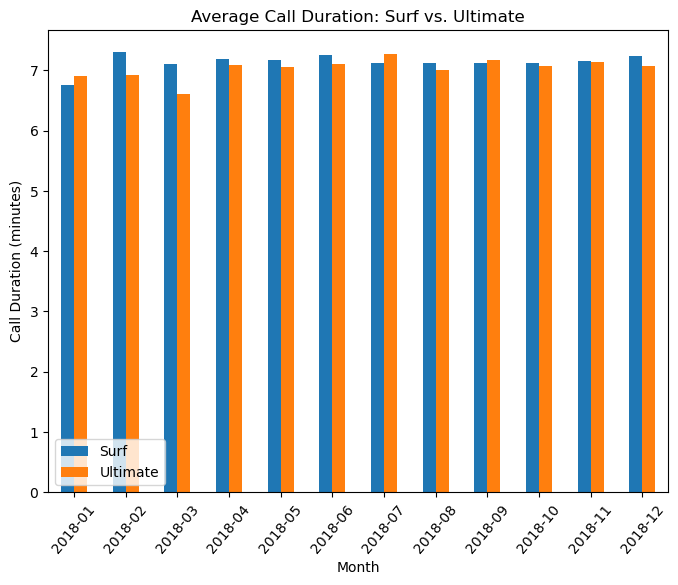

In [70]:
# merging call information with user plan data
calls_df_plan = calls_df.merge(users_df[['user_id', 'plan']], how = 'left', on ='user_id')

# Calculate average call duration per month for each plan
calls_avg = (calls_df_plan
             .groupby(['plan', pd.Grouper(key='call_date', freq='M')])
             ['duration_minutes']
             .mean()
             .reset_index()
             .pivot(index='call_date', columns='plan', values='duration_minutes')
             .rename(columns={'surf': 'avg_call_duration_surf', 'ult': 'avg_call_duration_ult'}))

calls_avg.index = calls_avg.index.to_period('M')

# Plotting
calls_avg.plot(kind='bar', 
               title='Average Call Duration: Surf vs. Ultimate', 
               xlabel='Month', 
               ylabel='Call Duration (minutes)', 
               rot=50, 
               figsize=(8,6))

plt.legend(['Surf', 'Ultimate'], loc='lower left')
plt.show()



From the graph, we can observe the following:

    - The average call duration for both plans is relatively consistent month over month.
    
    - Both Surf and Ultimate users have an average call duration that appears to fluctuate slightly but remains mostly between 6 to 7 minutes throughout the year.
    
    - There is no significant difference in the average call duration between Surf and Ultimate users in 
    any given month.
    

This consistency suggests that the choice of plan (Surf or Ultimate) does not affect how long users are on the phone, and it might indicate that users on both plans have similar needs or usage patterns when it comes to making calls.

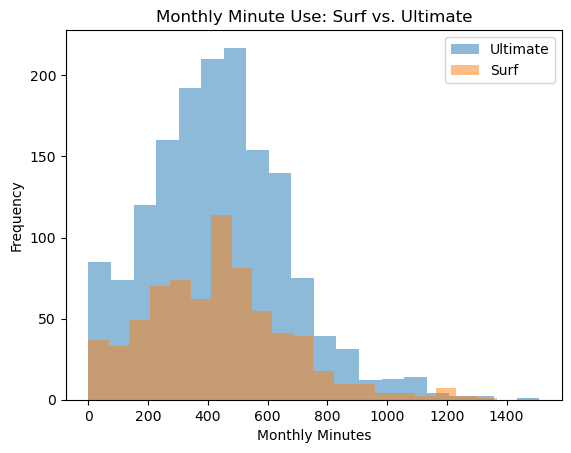

In [71]:
# Comparing the number of minutes users of each plan require each month - merging directly and plotting
(minutes_per_user
 .merge(users_df[['user_id', 'plan']], how='left', on='user_id')
 .groupby('plan')['total_minutes']
 .plot(kind='hist', bins=20, alpha=0.5, legend=True))

plt.xlabel('Monthly Minutes')
plt.ylabel('Frequency')
plt.title('Monthly Minute Use: Surf vs. Ultimate')
plt.legend(['Ultimate', 'Surf'], loc='upper right')
plt.show()


Plan Comparison: The Surf plan users (in brown) tend to use fewer minutes compared to Ultimate plan users (in blue). This could imply that the Surf plan might be tailored for users with lower usage needs or that it attracts more light users.

Usage Patterns:

    Surf: The histogram for Surf plan users appears to be right-skewed, indicating that the majority of users consume a smaller number of minutes, with a tail extending towards higher minute usage. This indicates that there are fewer high-usage customers on the Surf plan.
    
    Ultimate: The distribution for Ultimate plan users is more normally distributed but slightly right-skewed as well, suggesting that most customers use a moderate amount of minutes, with usage tapering off as the number of minutes increases.

Peak Usage: The peak usage (mode) for Surf plan users is lower than that for Ultimate plan users, suggesting that on average, Ultimate users tend to spend more time on calls.

In [72]:
# looking at mean, standard deviation, and variance of calls duration for both plans
calls_df_plan.groupby('plan').agg({'duration_minutes': ['mean', 'var', 'std']})

duration_minutes                     
                     mean        var       std
plan                                          
surf             7.168307  35.502268  5.958378
ultimate         7.100044  35.332282  5.944096

<Figure size 1000x600 with 0 Axes>

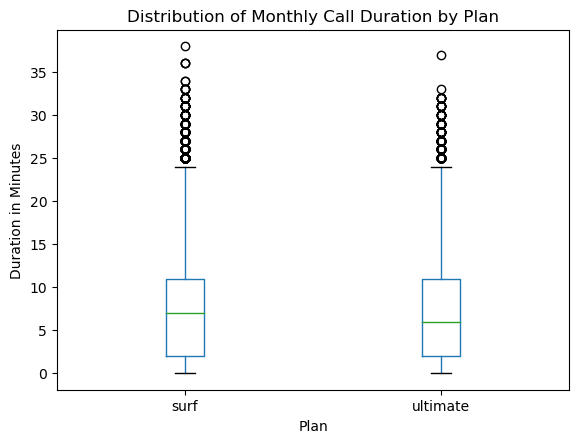

In [73]:
# Plot a boxplot to visualize the distribution of the monthly call duration for each plan
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size as needed
calls_df_plan.boxplot(by='plan', column=['duration_minutes'], grid=False)
plt.title('Distribution of Monthly Call Duration by Plan')
plt.suptitle('')  # Suppress the default title to avoid duplication
plt.xlabel('Plan')
plt.ylabel('Duration in Minutes')
plt.show()


From the graph, we can deduce:

    - Both plans have a similar range of call durations as indicated by the similar lengths of their boxes and whiskers.
    
    - The median call duration is also similar for both plans, as the line within each box is nearly at the same level.
    
    - There is a substantial number of outliers for both plans, indicating that there are quite a few users whose monthly call duration is much higher than average.
    
    - The distribution of call durations for both plans appears to be slightly right-skewed, as the median line is closer to the bottom of the box, and there are more outliers on the upper end.

Overall, the box plot suggests that while the average behavior is similar across both plans, there are individual users with significantly higher call durations. There doesn't appear to be a stark difference between the Surf and Ultimate plans in terms of the overall distribution of call durations.

### Messages

/var/folders/41/r7v088h101110hk6h74712800000gn/T/ipykernel_40878/1619247290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_messages['month'] = total_messages['month'].dt.to_timestamp()


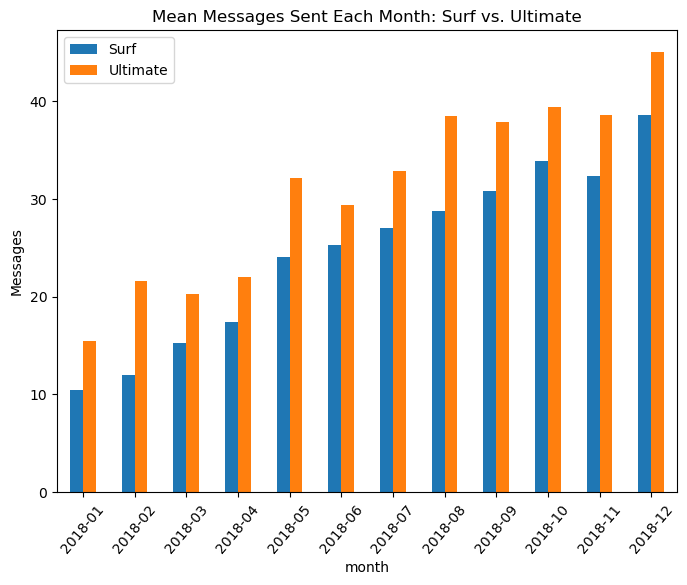

In [74]:
total_messages = total_monthly_usage[['user_id', 'month', 'total_messages_sent', 'plan']]
# Since 'month' is of PeriodDtype, convert it to Timestamp
total_messages['month'] = total_messages['month'].dt.to_timestamp()

# Set 'month' as the index
total_messages.set_index('month', inplace=True)

# Now group by 'plan' and resample by month, then plot
mean_messages = (total_messages
                 .groupby('plan')
                 .resample('M')['total_messages_sent']
                 .mean()
                 .unstack(level=0)  # Pivot the 'plan' level of the index into column headers
                )

mean_messages.index = mean_messages.index.to_period('M')

# Plot the bar chart
mean_messages.plot(kind='bar',
                   title='Mean Messages Sent Each Month: Surf vs. Ultimate',
                   ylabel='Messages',
                   rot=50,
                   figsize=(8,6))

plt.legend(['Surf', 'Ultimate'], loc='upper left')
plt.show()




From the graph, we can observe:

 
    - Starting from January (2018-01), the average number of messages sent by users of both plans appears to increase over the year, peaking around October (2018-10) for the Surf plan and December (2018-12) for 
    the Ultimate plan.

    - The Ultimate plan users generally sent more messages on average than the Surf users throughout the year.

    - The difference in the mean number of messages sent between the two plans seems to be 
    relatively consistent, with the Ultimate plan users always sending more messages than Surf plan users.

    - The increasing trend suggests that messaging activity for both plans grows as the year progresses. 
    This could be due to a variety of factors, such as an increase in users, seasonal behavior, or 
    changing communication habits.

In summary, users on the Ultimate plan consistently send more messages on average than those on the Surf plan, and there is a general upward trend in messaging activity for both plans as the year progresses.

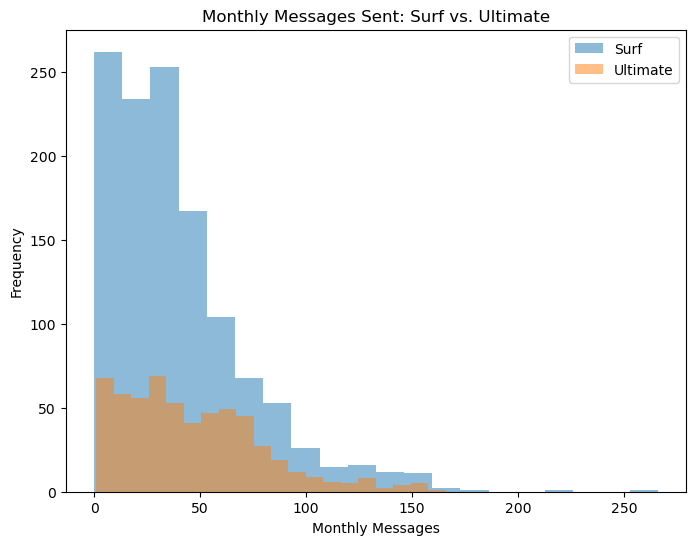

In [98]:
# Comparing the number of messages sent each month- merging directly and plotting
# setting figure size 
plt.figure(figsize=(8, 6))

# grouping data and plotting
(messages_per_user
 .merge(users_df[['user_id', 'plan']], how='left', on='user_id')
 .groupby('plan')['total_messages_sent']
 .plot(kind='hist', bins=20, alpha=0.5, legend=True))

# plotting data
plt.xlabel('Monthly Messages')
plt.ylabel('Frequency')
plt.title('Monthly Messages Sent: Surf vs. Ultimate')
plt.legend(['Surf', 'Ultimate'], loc='upper right')
plt.show()

Here's what we can infer from the graph:

    - The Surf plan histogram has a higher peak and is more skewed towards the lower number of monthly minutes, indicating a higher frequency of users with fewer monthly minutes.

    - The Ultimate plan histogram has a broader spread with a less pronounced peak, suggesting users' 
    monthly minutes are more evenly distributed across different usage levels.

    - Both distributions appear to have a right-skewed pattern, which means most of the users consume 
    fewer minutes, with a tail extending towards the higher number of minutes indicating fewer users with very high usage.

    - There is some overlap in the middle range of minutes, but the Surf plan seems to have a 
    higher concentration of users in the lower minute ranges.

    - The Ultimate plan users have a wider range of message usage with some users sending a significant 
    number of messages, as shown by the long tail of the brown histogram.


In [76]:
# grouping to find statistical data on monthly messages sent
total_messages.reset_index().groupby('plan').agg({'total_messages_sent': ['mean', 'var', 'std']})

total_messages_sent                        
                        mean          var        std
plan                                                
surf               31.159568  1126.724522  33.566717
ultimate           37.551389  1208.756744  34.767179

<Figure size 1000x600 with 0 Axes>

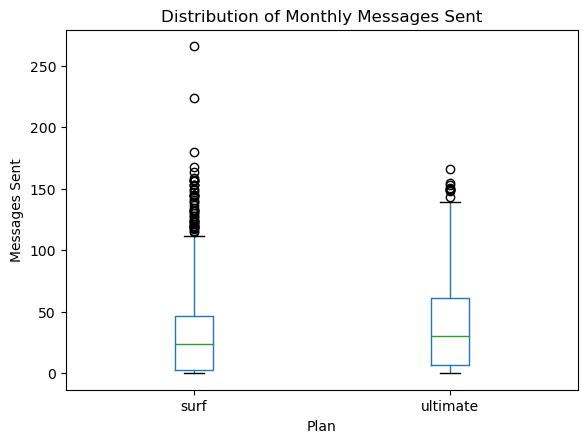

In [77]:
# Plot a boxplot to visualize the distribution of the monthly call duration for each plan
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size as needed
total_messages.boxplot(by='plan', column=['total_messages_sent'], grid=False)
plt.title('Distribution of Monthly Messages Sent')
plt.suptitle('')  # Suppress the default title to avoid duplication
plt.xlabel('Plan')
plt.ylabel('Messages Sent')
plt.show()


From the graph, we can infer:

    - Both plans have a similar median number of messages sent, as indicated by the line within each box.

    - The Surf plan has a wider IQR compared to the Ultimate plan, suggesting that the number of 
    messages sent by Surf users varies more from the lower to upper quartile.

    - The Surf plan also has a larger number of outliers that are significantly higher than the upper quartile, indicating that there are users who send a much higher number of messages compared to the typical Surf user.

    - The Ultimate plan's distribution has fewer outliers, and they are not as extreme as those for the 
    Surf plan, suggesting that Ultimate users tend to send a more consistent number of messages.

Overall, while the median number of messages sent is similar between the two plans, the variability and presence of extreme values are greater in the Surf plan compared to the Ultimate plan.

### Internet

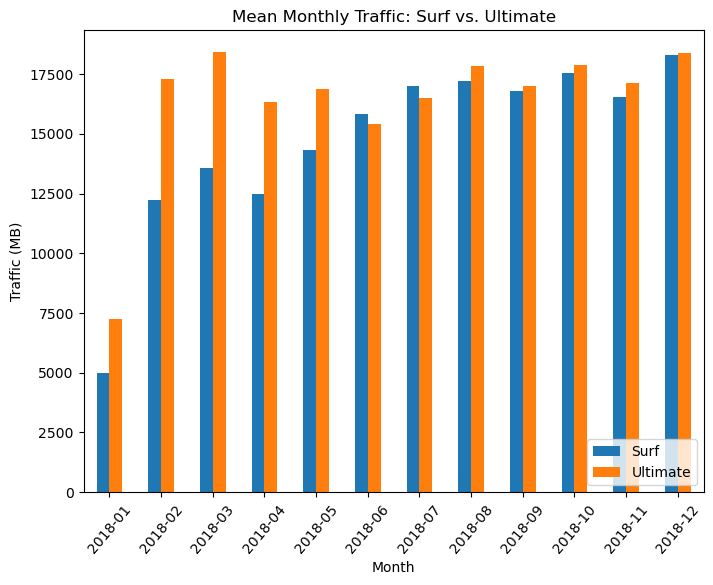

In [78]:
# Merge the user data with traffic data
traffic_plan = traffic_per_user.merge(users_df[['user_id', 'plan']], how='left', on='user_id')

# Calculate the average traffic for each plan per month directly without creating separate DataFrames
avg_monthly_traffic = (traffic_plan
                       .groupby(['month', 'plan'])
                       .agg(avg_monthly_traffic_mb=('total_traffic_mb', 'mean'))
                       .unstack('plan')
                x       .reset_index())

# Rename multi-level columns after unstacking
avg_monthly_traffic.columns = ['month', 'avg_monthly_traffic_surf', 'avg_monthly_traffic_ultimate']

# Plotting the data
avg_monthly_traffic.plot(x='month',
                         kind='bar',
                         title='Mean Monthly Traffic: Surf vs. Ultimate',
                         xlabel='Month',
                         ylabel='Traffic (MB)',
                         rot=50,
                         figsize=(8, 6))

# Add legend manually if it doesn't show up automatically
plt.legend(['Surf', 'Ultimate'], loc='lower right')
plt.show()


From the graph, we can observe:

    - Throughout the year, users on the Ultimate plan consistently use more data on average compared to users on the Ultimate plan. This is indicated by the height of the blue bars being greater than that of the orange 
    bars for each corresponding month.

    - The trend of data usage for both plans appears to increase slightly as the year progresses, with 
    the highest usage for both plans occurring in the last quarter of the year (from October to December).

    - The overall difference in mean data usage between the two plans remains fairly consistent month 
    over month.

The graph indicates that while both Surf and Ultimate plan users tend to increase their data usage towards the end of the year, Surf users, on average, consume more data than Ultimate users every month.

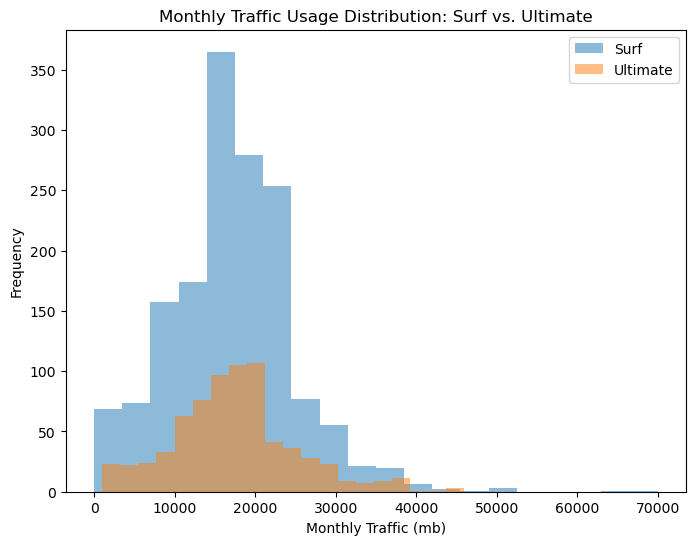

In [99]:
# Comparing the number of messages sent each month- merging directly and plotting
# setting figure size 
plt.figure(figsize=(8, 6))

# grouping data and plotting
(traffic_plan
 .groupby('plan')['total_traffic_mb']
 .plot(kind='hist', bins=20, alpha=0.5, legend=True))

# plotting data
plt.xlabel('Monthly Traffic (mb)')
plt.ylabel('Frequency')
plt.title('Monthly Traffic Usage Distribution: Surf vs. Ultimate')
plt.legend(['Surf', 'Ultimate'], loc='upper right')
plt.show()

Here's what we can infer from the graph:

    - The Surf plan shows a higher frequency of users across a wide range of data usage, particularly in the lower to middle data usage brackets.

    - The Ultimate plan users also have a spread of data usage, but the frequency of users at each level of data usage is lower compared to the Surf plan.

    - It appears that the Surf plan has more users with higher data consumption, as indicated by the greater frequency at the higher data usage levels.

    - There is some overlap in data usage between the plans, but the Surf plan's distribution extends further to the right, indicating users with very high data usage.

Overall, the histogram suggests that Surf plan users tend to use more data, with a broader distribution across various levels of data consumption, including the higher end, compared to users on the Ultimate plan.

In [80]:
# descriptive statistics of total traffic per month 
traffic_plan.reset_index().groupby('plan').agg({'total_traffic_mb': ['mean', 'var', 'std']})

total_traffic_mb                           
                     mean           var          std
plan                                                
surf         16820.397691  5.961727e+07  7721.222249
ultimate     17331.015299  5.849473e+07  7648.184954

<Figure size 1000x600 with 0 Axes>

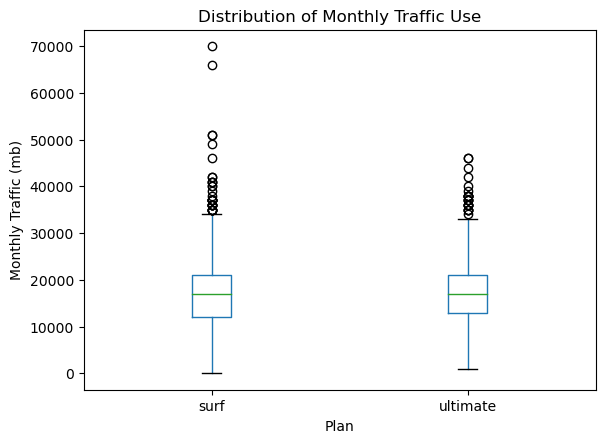

In [101]:
# Plot a boxplot to visualize the distribution of the monthly call duration for each plan
plt.figure(figsize=(10, 6))  
traffic_plan.boxplot(by='plan', column=['total_traffic_mb'], grid=False)
plt.title('Distribution of Monthly Traffic Use')
plt.suptitle('')  # Suppress the default title to avoid duplication
plt.xlabel('Plan')
plt.ylabel('Monthly Traffic (mb)')
plt.show()

Observations from the graph:

    - The median monthly traffic for both plans is around the same range, which we can infer from the 
    median line within each box.

    - Both plans have a number of outliers, but the Surf plan has more extreme values, indicating that 
    there are users with particularly high data usage compared to the rest.

    - The Ultimate plan has fewer outliers, and they are less extreme than those for the Surf plan, 
    indicating a more consistent data usage among its users.


## Revenue

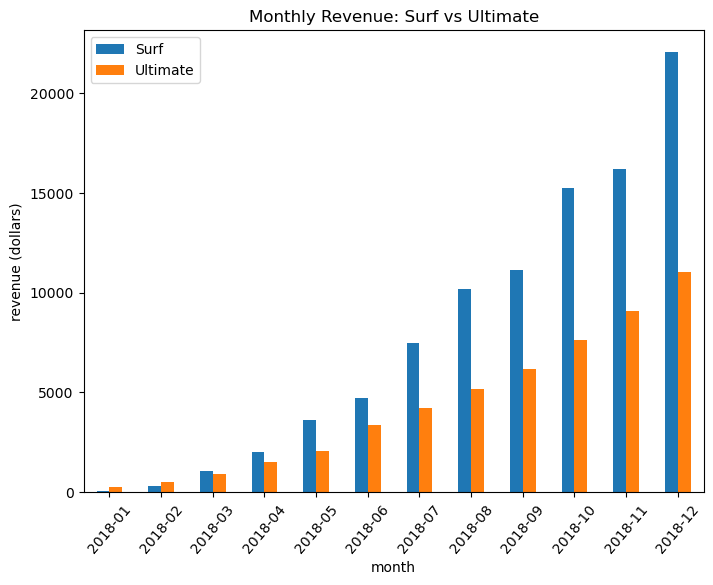

In [85]:
# creating pivot table and plotting bar graph
total_monthly_rev = total_monthly_usage[['user_id', 'month', 'revenue_usd', 'plan']]

(total_monthly_rev
 .pivot_table(index = 'month', columns = 'plan', values = 'revenue_usd', aggfunc = 'sum')
 .plot(kind = 'bar',
       title = 'Monthly Revenue: Surf vs Ultimate',
       xlabel = 'month',
       ylabel = 'revenue (dollars)',
       rot = 50,
       figsize = (8,6),))

plt.legend(['Surf', 'Ultimate'], loc = 'upper left')
plt.show()

From the graph, we can observe:


    - Throughout the year, the Surf plan consistently generates more revenue each month compared to 
    the Ultimate plan, as indicated by the blue bars being taller than the orange bars for each corresponding month.

    - For both plans, there is a visible increase in revenue as the year progresses, with the highest 
    revenue being generated in the last month, December (2018-12).

    - The revenue for the Surf plan particularly shows a sharp increase in the later months of the 
    year, starting around September (2018-09).

The graph indicates that the Surf plan is the larger revenue generator for the company on a month-by-month basis, and there is a trend of increasing revenue as the year goes on for both plans. The sharp increase for the Surf plan towards the end of the year could be due to a variety of factors, such as seasonal promotions, increased user acquisition, or changes in user behavior.

In [86]:
# pulling up descriptive statistics of revenue per customer
total_rev_per_user.reset_index().groupby('plan').agg({'revenue_usd': ['mean', 'var', 'std']})

revenue_usd                          
                mean           var         std
plan                                          
surf      282.305064  80554.241160  283.820791
ultimate  331.251244  50008.933012  223.626772

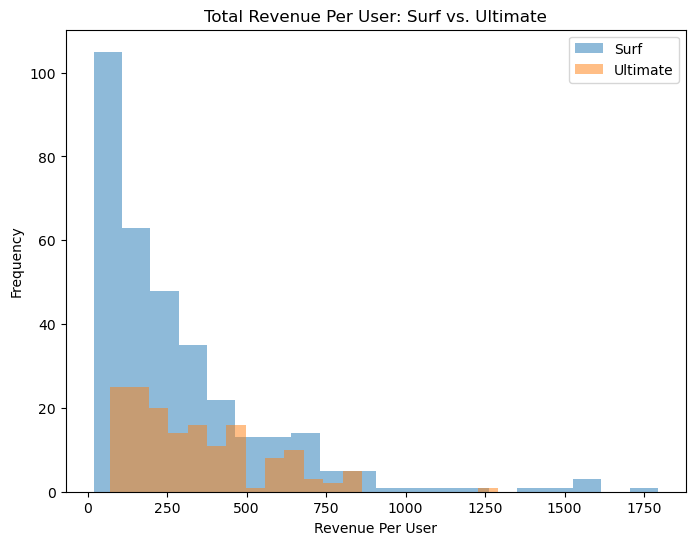

In [88]:
plt.figure(figsize=(8, 6))

# grouping data and plotting
(total_rev_per_user
 .groupby('plan')['revenue_usd']
 .plot(kind='hist', bins=20, alpha=0.5, legend=True))

# plotting data
plt.xlabel('Revenue Per User')
plt.ylabel('Frequency')
plt.title('Total Revenue Per User: Surf vs. Ultimate')
plt.legend(['Surf', 'Ultimate'], loc='upper right')
plt.show()

Here's an interpretation of the histogram:

    - The majority of Surf plan users fall into the lower revenue brackets, with a very high frequency of 
    users generating revenue in the lowest bracket (close to 0 dollars).

    - The distribution for Surf plan users tapers off as revenue per user increases, indicating fewer 
    users contribute to higher revenue brackets.

    - The distribution for Ultimate plan users is more evenly spread across different revenue brackets, although it also shows a higher concentration in lower revenue brackets. However, the frequency of users 
    in higher revenue brackets is more substantial compared to the Surf plan.

    - There's a notable overlap in the middle revenue brackets, where both Surf and Ultimate plan users contribute to the revenue, but the Surf plan has a more significant number of users in the lowest bracket, 
    and the Ultimate plan has more users in the higher revenue brackets.

This histogram suggests that while more Surf users contribute to lower revenue brackets, Ultimate users tend to generate more revenue on average per user. This could imply that the Ultimate plan may have a higher subscription cost or that Ultimate users purchase more additional services leading to higher individual revenue.

In [89]:
# pulling up descriptive statistics of revenue per customer
monthly_overages = total_monthly_usage.groupby(['month', 'plan'])['total_overages_dollars'].sum().reset_index()
monthly_overages.groupby('plan').agg({'total_overages_dollars': ['mean', 'var', 'std']})

total_overages_dollars                           
                           mean           var          std
plan                                                      
surf                5212.298854  2.555393e+07  5055.089146
ultimate             133.870443  1.815214e+04   134.729889

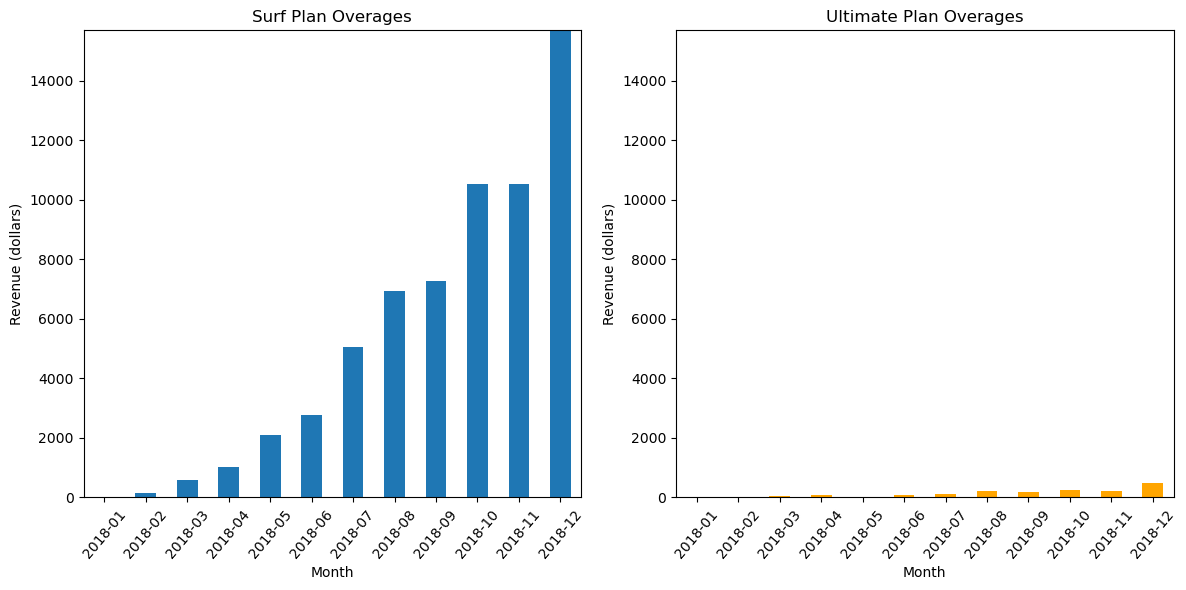

In [90]:
# creating separate dataframes for each plan
monthly_overages_surf = monthly_overages[monthly_overages['plan'] == 'surf']
monthly_overages_ult = monthly_overages[monthly_overages['plan'] == 'ultimate']


# finding the maximum revenue value between the two datasets for consistent y-axis limits
max_revenue = max(monthly_overages_surf['total_overages_dollars'].max(), monthly_overages_ult['total_overages_dollars'].max())

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for Surf plan
monthly_overages_surf.plot(kind='bar', x='month', y='total_overages_dollars',
                           ax=axes[0], title='Surf Plan Overages', legend=False, rot=50)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue (dollars)')
axes[0].set_ylim(0, max_revenue)  # Set the y-axis limit

# Plot for Ultimate plan
monthly_overages_ult.plot(kind='bar', x='month', y='total_overages_dollars', color='orange',
                          ax=axes[1], title='Ultimate Plan Overages', legend=False, rot=50)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Revenue (dollars)')
axes[1].set_ylim(0, max_revenue)  # Set the y-axis limit

# Display the plots
plt.tight_layout()
plt.show()




For the Surf Plan Overages (left graph):

    - There is a clear upward trend in overage revenue throughout the year, with the most significant 
    increase starting in July (2018-07) and peaking in December (2018-12).

    - This suggests that users on the Surf plan are increasingly exceeding their plan limits as the 
    year progresses, leading to higher overage charges.

For the Ultimate Plan Overages (right graph):

    - The revenue from overage charges is relatively minimal and consistent throughout the year.

    - There is a slight increase in overage revenue in December (2018-12), but it is not as pronounced as 
    with the Surf plan.

Overall, the Surf plan seems to generate significantly more revenue from overage charges compared to the Ultimate plan. This could indicate that the Surf plan has tighter limits on usage or that its users are more prone to exceeding their plan limits, resulting in more frequent or higher overage fees. In contrast, Ultimate plan users either tend to stay within their usage limits, or the plan may offer more generous limits, resulting in fewer overage charges.

In [92]:
monthly_overages
# Calculate and print the percentage of revenue due to overages for Surf Plan
print(f"Percentage of revenue due to overages for Surf Plan: "
      f"{(monthly_overages['surf'].sum() / total_monthly_rev[total_monthly_rev['plan'] == 'surf']['revenue_usd'].sum() * 100):.2f}%")

# Calculate and print the percentage of revenue due to overages for Ultimate Plan
print(f"Percentage of revenue due to overages for Ultimate Plan: "
      f"{(monthly_overages['ultimate'].sum() /  total_monthly_rev[total_monthly_rev['plan'] == 'ultimate']['revenue_usd'].sum() * 100):.2f}%")


Percentage of revenue due to overages for Surf Plan: 66.53%
Percentage of revenue due to overages for Ultimate Plan: 3.09%


# Testing Statistical Hypotheses <a id = 'test'></a>

<div class="alert alert-info" role="alert">
<b>Hypotheses:</b>
    

    
    H0: The average revenue per user for the Surf and Ultimate plans are equal to each other. 
    H1: The average revenue per user for the Surf and Ultimate plans are not equal to each other.   
    


In [93]:
# Calculate the mean revenue per user for each plan using a groupby operation
mean_revenue_per_plan = total_monthly_usage.groupby('plan')['revenue_usd'].mean()

# Print the mean revenue per user for both plans
print(f"Mean revenue per user for Surf Plan: ${mean_revenue_per_plan['surf']:.2f}")
print(f"Mean revenue per user for Ultimate Plan: ${mean_revenue_per_plan['ultimate']:.2f}")


Mean revenue per user for Surf Plan: $59.76
Mean revenue per user for Ultimate Plan: $72.23


In [94]:
# Test the hypotheses


p = .01

results = st.ttest_ind(rev_per_user_surf, rev_per_user_ult, equal_var = False)

print('P-Value:', results.pvalue)

if results.pvalue < p:
    print('We reject the null hypothesis.')
else:
    print('We cannot reject the null hypothesis.')

NameError: name 'rev_per_user_surf' is not defined

We reject the null hypothesis. This indicates that there is a significant difference in the mean's between these populations that needs to be explored further. 




<div class="alert alert-info"> 
<b>Hypotheses:</b> 

     H0: The average revenue for each user from NY-NJ is equal to user from other areas. 
     H1: The average revenue for each user from NY-NJ is not equal to revenue from users in other regions. 


</div>

In [95]:
# merging user demographic data with monthly usage data for testing 
geo_behavior = total_monthly_usage.merge(users_df[['user_id', 'city']], how = 'outer', on = 'user_id')

# separating dataframes by customer location
NY_NJ_users_rev = geo_behavior[geo_behavior['city'] =='New York-Newark-Jersey City, NY-NJ-PA MSA']['revenue_usd']
non_NY_NJ_rev = geo_behavior[geo_behavior['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['revenue_usd']

/Users/kevinklev/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


In [96]:
# identifying averages of both user groups
print(f'Average monthly revenue of customers in New York-New Jersey State MSA: ${NY_NJ_users_rev.mean():.2f}')
print(f'Average monthly revenue of customers NOT in New York-New Jersey State MSA: ${non_NY_NJ_rev.mean():.2f}')

Average monthly revenue of customers in New York-New Jersey State MSA: $59.22
Average monthly revenue of customers NOT in New York-New Jersey State MSA: $64.56


In [97]:
# Test the hypotheses

target_value = non_NY_NJ_rev.mean()

alpha_1 = .05 

results_1 = st.ttest_1samp(NY_NJ_users_rev, target_value)

print('P-Value:', results_1.pvalue)

if results_1.pvalue < alpha_1:
    print('We reject the null hypothesis')
else:
    print('We cannot reject the null hypothesis')



P-Value: nan
We cannot reject the null hypothesis


After running this test, we cannot reject the null hypothesis. There is no significance in the difference between those in the NY-NJ MSA and customers in other regions. 


## Conclusion <a id = 'end'></a>



Upon analyzing user behavior in relation to messaging, data consumption, and call duration, we observe negligible variances in usage patterns when contrasting the Surf and Ultimate plans. Minor monthly fluctuations are present, but the selection of the plan appears to have a marginal impact on consumer behavior.

Financially, the Ultimate plan's users contribute more revenue on average compared to those on the Surf plan. This is likely due to the greater number of subscribers associated with the Surf plan, which typically correlates with increased revenue generation. Approximately 97% of the revenue from the Ultimate plan is derived from its base fee, while around 70% of the Surf plan's revenue is accrued from overage charges. Although the total revenue from the Surf plan is higher, the Ultimate plan yields a greater revenue per user, offering more predictable and stable financial returns.

In conclusion, it is advisable for the company to focus its marketing efforts on promoting the Ultimate plan. The existing disparity in revenue is largely a result of the higher user base for the Surf plan. By increasing the subscriber count for the Ultimate plan, the company could potentially realize an enhanced and more reliable revenue stream.
    

